In [1]:
print('Inicializando Variáveis do Programa')

ano_início = 2014
ano_fim = 2020
confiança = 0.01

Inicializando Variáveis do Programa


In [2]:
from datetime import datetime
print('Início em: ', datetime.now())

print('Importações Iniciais')

from tkinter import NONE
from Lattes import Lattes
from Carga import Carga
from Database import Database
import psycopg2, pickle
import os, math
import statsmodels.api as sm
from urllib.parse import urlencode
from psycopg2.extensions import AsIs
from Carga import Carga
import numpy as np
import Database
import json
import locale
import pylab
from scipy import stats
from scipy.stats import norm, skewnorm, shapiro, kstest
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm2
import seaborn as sns
from yellowbrick.regressor import ResidualsPlot 

print('Fim: ', datetime.now())

Início em:  2023-04-23 09:54:57.647325
Importações Iniciais
Fim:  2023-04-23 09:55:40.782911


In [3]:
#Carregar arquivo na memória
print('Carregando indicadores na memória. Início em: ', datetime.now())

db = Database.Database('CNPq')
engine = Carga.db_engine()
dt = pd.read_sql('''
select * from financiamentos_doutorandos_2014
inner join indicadores_doutorado
on indicadores_doutorado.id = financiamentos_doutorandos_2014.id
''', engine)
print(f'dt.size: {dt.size}')

print('Término em: ', datetime.now())

Carregando indicadores na memória. Início em:  2023-04-23 09:55:40.800932
dt.size: 12911456
Término em:  2023-04-23 09:56:11.179671


In [4]:
## Normalizando as Tabelas

print('Realizando normalização da tabela. Início em: ', datetime.now())

dt['bool_cnpq'] = dt['pagtos'].map(lambda pagtos: 1 if pagtos > 0 else 0)
dt['bool_capes'] = dt['capes'].map(lambda capes: 1 if capes == True else 0)
dt['const'] = 1
dt = dt.loc[:,~dt.columns.duplicated()]


#Preenchendo Nan com zeros nos indicadores
dt.qty_2012 = dt.qty_2012.fillna(0)
dt.qty_2013 = dt.qty_2013.fillna(0)
dt.qty_2014 = dt.qty_2014.fillna(0)
dt.qty_2015 = dt.qty_2015.fillna(0)
dt.qty_2016 = dt.qty_2016.fillna(0)
dt.qty_2017 = dt.qty_2017.fillna(0)
dt.qty_2018 = dt.qty_2018.fillna(0)
dt.qty_2019 = dt.qty_2019.fillna(0)
dt.capes = dt.capes.fillna(0)
dt.pagtos = dt.pagtos.fillna(0)
dt.bool_cnpq = dt.bool_cnpq.fillna(0)
dt.bool_capes = dt.bool_capes.fillna(0)

print('Fim em: ', datetime.now())


Realizando normalização da tabela. Início em:  2023-04-23 09:56:11.201668
Fim em:  2023-04-23 09:56:13.507754


In [5]:
dt.drop(dt[np.logical_and(dt['bool_cnpq'] == 1, dt['bool_capes'] == 1)].index, inplace=True)
dt['qty_2014_log'] = np.log(dt.qty_2014)**(0.5)
dt['qty_2019_log'] = np.log(dt.qty_2019)**(0.5)


C:\Python\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
dt['group'] = dt.apply(lambda dt: 'CAPES' if dt['bool_capes'] == 1 else 'CNPq' if dt['bool_cnpq'] == 1 else 'Nenhum', axis=1)


In [7]:
def regressão(X,y):
    try:
        # OLS vem de Ordinary Least Squares e o método fit irá treinar o modelo
        reg = sm.OLS(y, X).fit()
        # mostrando as estatísticas do modelo
        #reg.summary()
        
        
        
        #guardando a regressão na memória

        result = {
                'Indicador': indicador,
                'Erro': False,
                'Prob (F-statistic)':reg.f_pvalue, 
                'Parâmetros': reg.params, 
                "P>|t|":reg.pvalues, 
                'Standard Error': reg.bse, 
                "Covariância entre os pasrâmetros": reg.normalized_cov_params, 
                'Number of observations n.': reg.nobs, 
                "R2 ajustado": reg.rsquared_adj, 
                "Modelo":reg.model,
            }
    except:
        result = {
                'Indicador': indicador,
                'Erro': True,
                'Prob (F-statistic)':None, 
                'Parâmetros': None, 
                "P>|t|":None, 
                'Standard Error': None, 
                "Covariância entre os pasrâmetros": None, 
                'Number of observations n.': None, 
                "R2 ajustado": None, 
                "Modelo": None,
            }
    return result

In [8]:
def regressão_com_confiança (X,y,confiança = 0.05): 
    result = regressão(X,y)
    #print(result)
    while result['Erro'] == False and result['P>|t|'].max() > confiança:
        X = X.drop(columns=result['P>|t|'].idxmax())
        result = regressão(X,y)
        #print(result)
    if result['Erro'] == False and result['Prob (F-statistic)'] < confiança and result['P>|t|'].max() < confiança:
        result['Confiança'] = confiança
        return result
    else:
        result['Confiança'] = 'Erro'
    return result


In [9]:
list(dt.indicador_tipo.unique())

['@ANO-DA-PREMIACAO PREMIO-TITULO ',
 '@ANO-DE-CONCLUSAO DOUTORADO ',
 '@ANO-DE-CONCLUSAO ESPECIALIZACAO ',
 '@ANO-DE-CONCLUSAO GRADUACAO ',
 '@ANO-DE-CONCLUSAO MESTRADO ',
 '@ANO-DE-INICIO DOUTORADO ',
 '@ANO-DE-INICIO ESPECIALIZACAO ',
 '@ANO-DE-INICIO GRADUACAO ',
 '@ANO-DE-INICIO MESTRADO ',
 '@ANO-DE-OBTENCAO-DO-TITULO DOUTORADO ',
 '@ANO-DE-OBTENCAO-DO-TITULO MESTRADO ',
 '@ANO-DE-REALIZACAO DETALHAMENTO-DO-TRABALHO ',
 '@ANO-DO-ARTIGO ARTIGO-PUBLICADO ',
 '@ANO-DO-TRABALHO TRABALHO-EM-EVENTOS ',
 '@ANO-FIM DIRECAO-E-ADMINISTRACAO ',
 '@ANO-FIM ENSINO ',
 '@ANO-FIM EXTENSAO-UNIVERSITARIA ',
 '@ANO-FIM SERVICO-TECNICO-ESPECIALIZADO ',
 '@ANO-FIM TREINAMENTO-MINISTRADO ',
 '@ANO-FIM VINCULOS ',
 '@ANO-INICIO DIRECAO-E-ADMINISTRACAO ',
 '@ANO-INICIO ENSINO ',
 '@ANO-INICIO EXTENSAO-UNIVERSITARIA ',
 '@ANO-INICIO SERVICO-TECNICO-ESPECIALIZADO ',
 '@ANO-INICIO TREINAMENTO-MINISTRADO ',
 '@ANO-INICIO VINCULOS ',
 '@ANO APRESENTACAO-DE-TRABALHO ',
 '@ANO DEMAIS-TRABALHOS ',
 '@ANO ORGAN

In [10]:
indicador = '@ANO-DO-ARTIGO ARTIGO-PUBLICADO '
dados = dt.loc[dt.indicador_tipo==indicador]


In [11]:
modelo_ajustado = sm2.ols(formula = 'qty_2019 ~ qty_2014 + bool_capes + bool_cnpq', data = dados)
modelo_treinado = modelo_ajustado.fit()
modelo_treinado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               qty_2019   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     9329.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:56:36   Log-Likelihood:                -62169.
No. Observations:               19173   AIC:                         1.243e+05
Df Residuals:                   19169   BIC:                         1.244e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6209      0.072     36.160      0.000       2.479       2.763
qty_2014       1.5334      0.009    167.253      0.000       1.515       1.551
bool_capes     1.3047      0.096     13.612      0.000       1.117       1.493
bool_cnpq      1.5844      0.145     10.936      0.000       1.300       1.868
==============================================================================
Omnibus:                    25788.554   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25416720.190
Skew:                           7.120   Prob(JB):                         0.00
Kurtosis:                     180.800   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

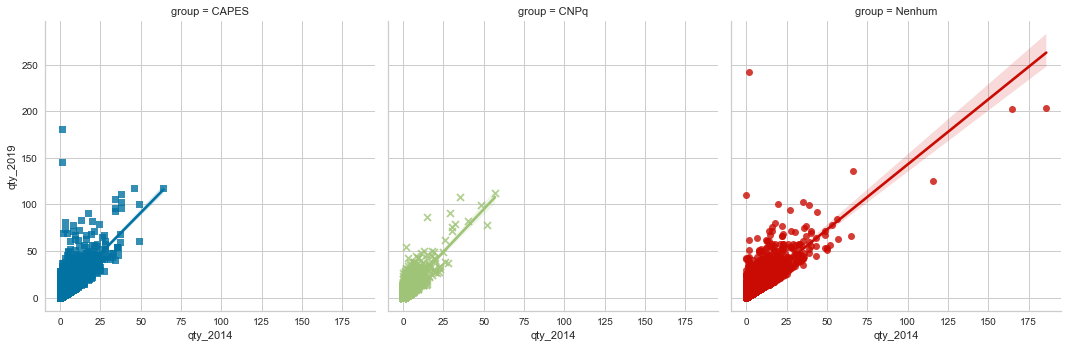

In [12]:
sns_plot = sns.lmplot(x = "qty_2014", y = "qty_2019",
           col = 'group', hue = "group", markers = ["s", "x", "o"], data = dados)

In [13]:
sns_plot.savefig('Data and regression model fits across a FacetGrid.png', dpi=600)

C:\Python\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


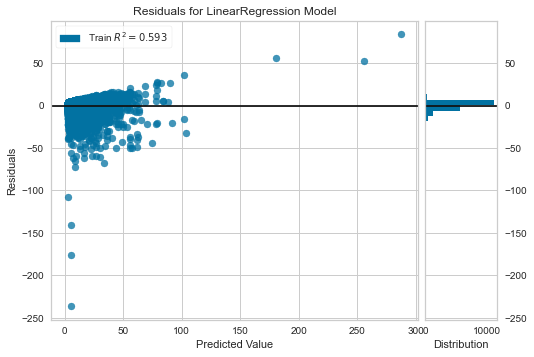

C:\Python\anaconda3\lib\site-packages\yellowbrick\base.py:244: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "title" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(outpath, **kwargs)


<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

<Figure size 576x396 with 0 Axes>

In [14]:
# Gráfico para visualizar os residuais
X = dados[['const','qty_2014', 'bool_cnpq','bool_capes']]
y = dados[['qty_2019']]
modelo = LinearRegression()
modelo.fit(X, y)
visualizador = ResidualsPlot(modelo)
visualizador.fit(X, y)
visualizador.poof()
visualizador.show(title='Test', outpath="Gráfico de Distribuição dos Residuais de Artigos Publicados.png")


In [15]:
dados.qty_2014.describe()

count    19173.000000
mean         3.085589
std          4.892889
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        186.000000
Name: qty_2014, dtype: float64

In [16]:
dados = dados.drop(dados.loc[dados.qty_2014 > (4*dados.qty_2014.std())].index)

In [17]:
dados.qty_2014.describe()

count    18914.000000
mean         2.720524
std          3.252310
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         19.000000
Name: qty_2014, dtype: float64

In [18]:
dados.qty_2019.describe()

count    18914.000000
mean         7.509517
std          7.927041
min          0.000000
25%          3.000000
50%          5.000000
75%         10.000000
max        242.000000
Name: qty_2019, dtype: float64

In [19]:
dados = dados.drop(dados.loc[dados.qty_2019 > (4*dados.qty_2019.std())].index)

In [20]:
dados.qty_2019.describe()

count    18578.000000
mean         6.874475
std          5.925482
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         31.000000
Name: qty_2019, dtype: float64

In [21]:
X = dados[['const','qty_2014', 'bool_cnpq','bool_capes']]
y = dados[['qty_2019']]

In [22]:
modelo_ajustado = sm2.ols(formula = 'qty_2019 ~ qty_2014 + bool_capes + bool_cnpq', data = dados)
modelo_treinado = modelo_ajustado.fit()
modelo_treinado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               qty_2019   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     6114.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:56:59   Log-Likelihood:                -53035.
No. Observations:               18578   AIC:                         1.061e+05
Df Residuals:                   18574   BIC:                         1.061e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7144      0.054     50.706      0.000       2.609       2.819
qty_2014       1.3855      0.010    135.224      0.000       1.365       1.406
bool_capes     1.0389      0.066     15.720      0.000       0.909       1.168
bool_cnpq      1.3824      0.100     13.838      0.000       1.187       1.578
==============================================================================
Omnibus:                     6525.136   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23970.550
Skew:                           1.757   Prob(JB):                         0.00
Kurtosis:                       7.314   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
reg = sm.OLS(y, X).fit()
print('params')
print(reg.params)
print('\ntvalues')
print(reg.tvalues)

params
const         2.714390
qty_2014      1.385514
bool_cnpq     1.382449
bool_capes    1.038894
dtype: float64

tvalues
const          50.706243
qty_2014      135.224144
bool_cnpq      13.838011
bool_capes     15.719797
dtype: float64


In [24]:
modelo_ajustado = sm2.ols(formula = 'qty_2019 ~ qty_2014 + bool_cnpq + bool_capes', data = dados)
modelo_treinado = modelo_ajustado.fit()
modelo_treinado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               qty_2019   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     6114.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:57:00   Log-Likelihood:                -53035.
No. Observations:               18578   AIC:                         1.061e+05
Df Residuals:                   18574   BIC:                         1.061e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7144      0.054     50.706      0.000       2.609       2.819
qty_2014       1.3855      0.010    135.224      0.000       1.365       1.406
bool_cnpq      1.3824      0.100     13.838      0.000       1.187       1.578
bool_capes     1.0389      0.066     15.720      0.000       0.909       1.168
==============================================================================
Omnibus:                     6525.136   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23970.550
Skew:                           1.757   Prob(JB):                         0.00
Kurtosis:                       7.314   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

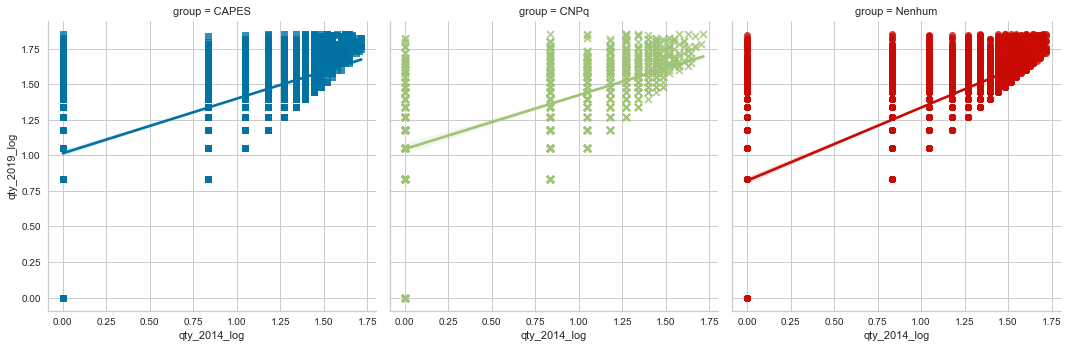

In [40]:
sns.lmplot(x = "qty_2014_log", y = "qty_2019_log",
           col = 'group', hue = "group", markers = ["s", "x", "o"], data = dados)

In [49]:
dados_log = dados[['const','qty_2014_log', 'bool_cnpq','bool_capes', 'qty_2019_log']]
dados_log.dropna(inplace=True)
X = dados_log[['const','qty_2014_log', 'bool_cnpq','bool_capes']]
y = dados_log[['qty_2019_log']]


C:\Python\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


C:\Python\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


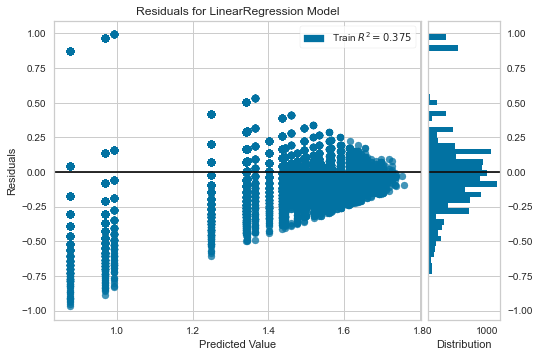

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [50]:
# Gráfico para visualizar os residuais
modelo = LinearRegression()
modelo.fit(X, y)
visualizador = ResidualsPlot(modelo)
visualizador.fit(X, y)
visualizador.poof()

In [56]:
modelo = sm2.ols(formula = 'qty_2019_log ~ qty_2014_log + bool_cnpq + bool_capes', data = dados_log)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           qty_2019_log   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     2781.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:10:50   Log-Likelihood:                -4072.1
No. Observations:               13903   AIC:                             8152.
Df Residuals:                   13899   BIC:                             8182.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8758      0.006    155.490      0.000       0.865       0.887
qty_2014_log     0.4470      0.005     90.376      0.000       0.437       0.457
bool_cnpq        0.1163      0.009     12.864      0.000       0.099       0.134
bool_capes       0.0914      0.006     15.540      0.000       0.080       0.103
==============================================================================
Omnibus:                     2061.771   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3974.874
Skew:                          -0.929   Prob(JB):                         0.00
Kurtosis:                       4.847   Cond. No.                         4.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
dados.qty_2014_log.describe()

count    13903.000000
mean         0.781932
std          0.557062
min          0.000000
25%          0.000000
50%          0.832555
75%          1.177410
max          1.715937
Name: qty_2014_log, dtype: float64

Text(0.5, 1.0, 'Dados')

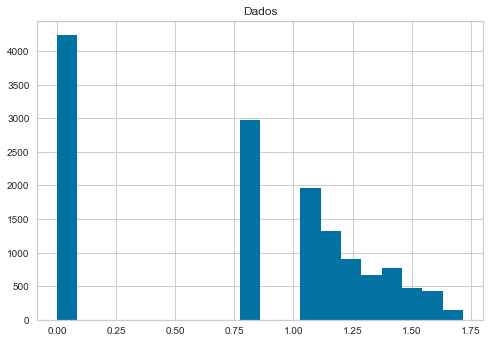

In [28]:
plt.hist(dados.qty_2014_log, bins=20)
plt.title('Dados')

<function matplotlib.pyplot.show(close=None, block=None)>

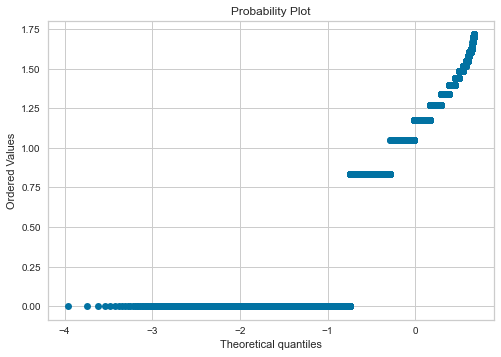

In [29]:
fig, ax = plt.subplots()
stats.probplot(dados.qty_2014_log, fit=True, plot=ax)
plt.show

In [30]:
stats.shapiro(dados.qty_2014_log)

C:\Python\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=nan, pvalue=1.0)

In [31]:
my_data = dados.qty_2014
ks_statistic, p_value = kstest(my_data, 'norm')
print(ks_statistic, p_value)

0.5897030192949397 0.0


In [32]:
transformed_data, lambda_ = stats.boxcox(dados.qty_2014+1)
stat, p = shapiro(transformed_data)
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

Shapiro-Wilk test statistic: 0.9208037853240967
p-value: 0.0


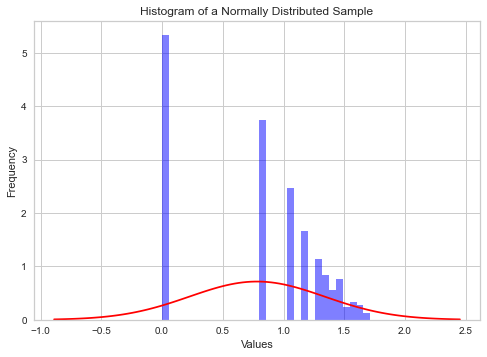

In [33]:


# Generate a random sample from a normal distribution
sample = dados.qty_2014_log

# Plot a histogram of the sample
plt.hist(sample, bins=30, density=True, alpha=0.5, color='blue')

# Add a line for the normal distribution with the same mean and standard deviation as the sample
mu, sigma = np.mean(sample), np.std(sample)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2)), color='red')

# Set the plot title and labels
plt.title("Histogram of a Normally Distributed Sample")
plt.xlabel("Values")
plt.ylabel("Frequency")

# Show the plot
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1bc25c797c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1bc25c79ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bc25c79430>],
 'medians': [<matplotlib.lines.Line2D at 0x1bc25c5d640>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bc25c5d9d0>],
 'means': []}

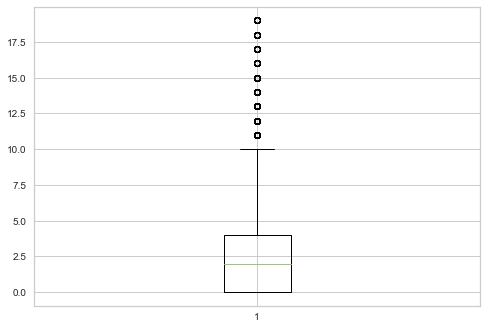

In [34]:
plt.boxplot(dados.qty_2014)

In [35]:
modelo_ajustado = sm2.ols(formula = 'qty_2019_log ~ qty_2014_log + bool_cnpq + bool_capes', data = dados)
modelo_treinado = modelo_ajustado.fit()
modelo_treinado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           qty_2019_log   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     2781.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:57:24   Log-Likelihood:                -4072.1
No. Observations:               13903   AIC:                             8152.
Df Residuals:                   13899   BIC:                             8182.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8758      0.006    155.490      0.000       0.865       0.887
qty_2014_log     0.4470      0.005     90.376      0.000       0.437       0.457
bool_cnpq        0.1163      0.009     12.864      0.000       0.099       0.134
bool_capes       0.0914      0.006     15.540      0.000       0.080       0.103
==============================================================================
Omnibus:                     2061.771   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3974.874
Skew:                          -0.929   Prob(JB):                         0.00
Kurtosis:                       4.847   Cond. No.                         4.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

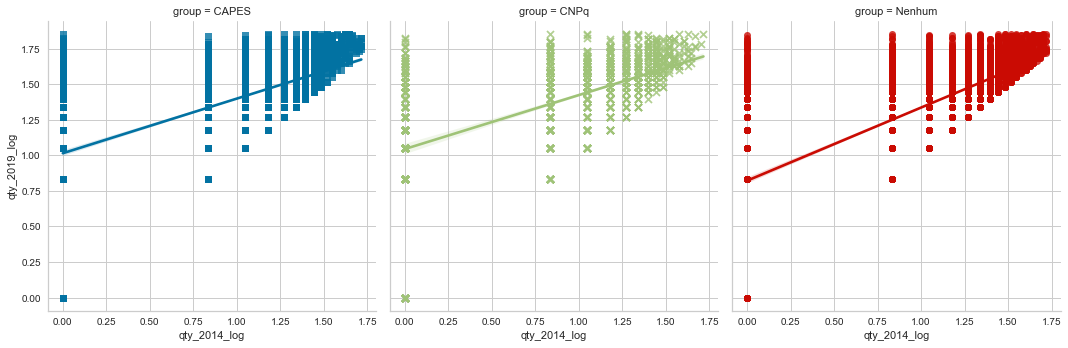

In [36]:
sns.lmplot(x = "qty_2014_log", y = "qty_2019_log",
           col = 'group', hue = "group", markers = ["s", "x", "o"], data = dados)

In [37]:
X = dados[['const','qty_2014_log', 'bool_cnpq','bool_capes']]
y = dados[['qty_2019_log']]

In [38]:
# Gráfico para visualizar os residuais
modelo = LinearRegression()
modelo.fit(X, y)
visualizador = ResidualsPlot(modelo)
visualizador.fit(X, y)
visualizador.poof()

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values